Importing Libraries

In [1]:
%matplotlib inline
import numpy 
import pandas
import matplotlib.pyplot as plt
import scipy.stats as stats
import pylab

import collections
from collections import Counter

from surprise import Dataset, Reader
from surprise import SVD, accuracy
from surprise.model_selection import cross_validate, train_test_split

Getting dataset from grouplens (grouplens.org). The one being used here is the 1M dataset.

In [2]:
movie_data = pandas.read_table('ml-1m/movies.dat', sep = '::', names = ['movie_id', 'movie', 'genre'])
users_data = pandas.read_table('ml-1m/users.dat', sep = '::', names = ['user_id', 'gender', 'age', 'occupation', 'zipcode'])
ratings_data = pandas.read_table('ml-1m/ratings.dat', sep = '::', names = ['user_id', 'movie_id', 'rating', 'time'])

/home/shrvnchndra/Jupyter/lib/python3.8/site-packages/pandas/io/parsers.py:755: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return read_csv(**locals())


In [3]:
print(movie_data.head())
print(users_data.head())
print(ratings_data.head())

   movie_id                               movie                         genre
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy
   user_id gender  age  occupation zipcode
0        1      F    1          10   48067
1        2      M   56          16   70072
2        3      M   25          15   55117
3        4      M   45           7   02460
4        5      M   25          20   55455
   user_id  movie_id  rating       time
0        1      1193       5  978300760
1        1       661       3  978302109
2        1       914       3  978301968
3        1      3408       4  978300275
4        1      2355       5  978824291


Since the year of release is combined with the movie name, we need to extract the year of release. So, we use the split function, and then create separate columns for name and year.

In [4]:
movie = movie_data.movie.str.split(pat='(', expand=True, n=1)
movie_name = movie.iloc[:,0]
movie_year = movie.iloc[:,1].str.split(pat=')', expand=True, n=1).iloc[:,0]

movie_data.drop(['movie'], axis=1, inplace=True)
movie_data['movie_name'] = movie_name
movie_data['movie_year'] = movie_year

Since the genre is separated by '|', we use the same split function to split the genres and make them into a list.

In [5]:
new_genre = []
for string in movie_data.genre:
    new_genre.append(string.split('|'))
movie_data['genre'] = new_genre

In [6]:
print(movie_data.head())
print(users_data.head())
print(ratings_data.head())

   movie_id                             genre                    movie_name  \
0         1   [Animation, Children's, Comedy]                    Toy Story    
1         2  [Adventure, Children's, Fantasy]                      Jumanji    
2         3                 [Comedy, Romance]             Grumpier Old Men    
3         4                   [Comedy, Drama]            Waiting to Exhale    
4         5                          [Comedy]  Father of the Bride Part II    

  movie_year  
0       1995  
1       1995  
2       1995  
3       1995  
4       1995  
   user_id gender  age  occupation zipcode
0        1      F    1          10   48067
1        2      M   56          16   70072
2        3      M   25          15   55117
3        4      M   45           7   02460
4        5      M   25          20   55455
   user_id  movie_id  rating       time
0        1      1193       5  978300760
1        1       661       3  978302109
2        1       914       3  978301968
3        1      3

Movie Rating Distribution - We shall look into, how the movies has been rated, i.e. the frequency of the ratings.

In [7]:
movie_ratings = ratings_data['rating'].value_counts()
movie_ratings

4    348971
3    261197
5    226310
2    107557
1     56174
Name: rating, dtype: int64

In [8]:
all_movie_ratings = ratings_data['rating']
all_movie_ratings = sorted(all_movie_ratings)

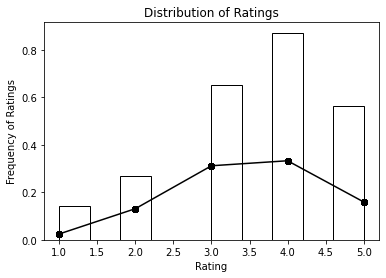

In [9]:
fit = stats.norm.pdf(all_movie_ratings, numpy.mean(all_movie_ratings), numpy.std(all_movie_ratings))
pylab.plot(all_movie_ratings, fit, '-ko')
pylab.hist(all_movie_ratings, density=True, color= 'black', fill = False)
pylab.xlabel("Rating")
pylab.ylabel("Frequency of Ratings")
pylab.title("Distribution of Ratings")
pylab.show()

Plotting without normalizing the frequencies.

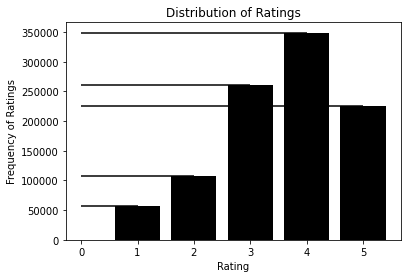

In [10]:
ratings_sorted = sorted(list(zip(movie_ratings.index, movie_ratings)))
plt.bar([rating[0] for rating in ratings_sorted],
        [rating[1] for rating in ratings_sorted],
        color = 'black')
plt.xlabel("Rating")
plt.ylabel("Frequency of Ratings")
plt.title("Distribution of Ratings")

for index in range(len(ratings_sorted)):
     plt.hlines(ratings_sorted[index][1],0,ratings_sorted[index][0])
    
plt.show()

Analysis of Frequency of Genre

In [11]:
new_genre = movie_data.genre
new_genre = [item for array in new_genre for item in array]
genre_count = collections.OrderedDict(sorted(Counter(new_genre).items()))
genre_count

OrderedDict([('Action', 503),
             ('Adventure', 283),
             ('Animation', 105),
             ("Children's", 251),
             ('Comedy', 1200),
             ('Crime', 211),
             ('Documentary', 127),
             ('Drama', 1603),
             ('Fantasy', 68),
             ('Film-Noir', 44),
             ('Horror', 343),
             ('Musical', 114),
             ('Mystery', 106),
             ('Romance', 471),
             ('Sci-Fi', 276),
             ('Thriller', 492),
             ('War', 143),
             ('Western', 68)])

In [12]:
genre_list = list(genre_count.keys())
genre_list_count = list(genre_count.values())

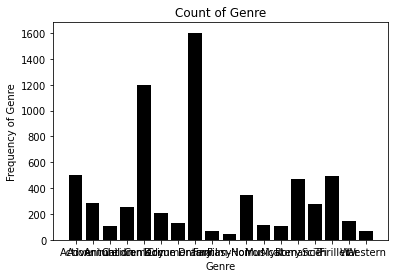

In [13]:
plt.bar([genre for genre in genre_list],
        [count for count in genre_list_count],
        color = 'black')
plt.xlabel("Genre")
plt.ylabel("Frequency of Genre")
plt.title("Count of Genre")
plt.show()

Analsis of Frequency of User Reviews

In [14]:
print("Number of users: ", ratings_data.user_id.nunique()) 
print("Average Number of Reviews per User: ", ratings_data.shape[0]/ratings_data.user_id.nunique())

Number of users:  6040
Average Number of Reviews per User:  165.5975165562914


In [15]:
ratings_per_user = ratings_data['user_id'].value_counts()
ratings_per_user = sorted(list(zip(ratings_per_user.index, ratings_per_user)))
# ratings_per_user

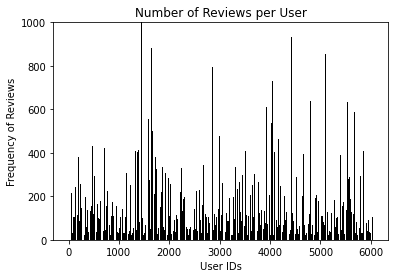

In [16]:
plt.bar([rating[0] for rating in ratings_per_user],
        [rating[1] for rating in ratings_per_user],
        color = 'black')
plt.xlabel("User IDs")
plt.ylim(top=1000)
plt.ylabel("Frequency of Reviews")
plt.title("Number of Reviews per User")
plt.show()

In [17]:
user_ratings = [ratings[1] for ratings in ratings_per_user]
user_ratings_sorted = sorted(Counter(user_ratings).items())

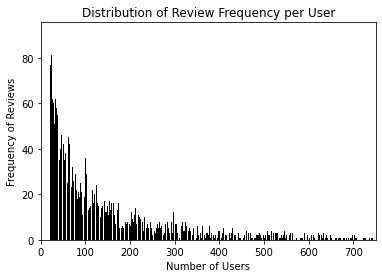

In [18]:
plt.bar([ratings[0] for ratings in user_ratings_sorted][:-1],
        [ratings[1] for ratings in user_ratings_sorted][:-1],
        color = 'black')
plt.xlabel("Number of Users")
plt.xlim(left = 0, right=750)
plt.ylabel("Frequency of Reviews")
plt.title("Distribution of Review Frequency per User")
plt.show()

Analysis of Genre based on Age and Gender - Depending on the age and gender, analysis shall be done to see, what kinda genre is preferred.

First, data has to be extracted from users data, for female and male. Age is extracted from this.

In [19]:
female_data = users_data.loc[users_data['gender'] == 'F', ['user_id', 'age']]
male_data = users_data.loc[users_data['gender'] == 'M', ['user_id', 'age']]

Next, the extracted data will be merged with ratings data, on user id. Movies id is extracted.

In [20]:
female_data = (female_data.merge(ratings_data, left_on='user_id', right_on='user_id')
               .reindex(columns=['age', 'user_id', 'movie_id']))
male_data = (male_data.merge(ratings_data, left_on='user_id', right_on='user_id')
               .reindex(columns=['age', 'user_id', 'movie_id']))

The newly formed data in now merged with movies data on movie id. Here, the genres are extracted. And then, user id and movie id is dropped since it is not required anymore.

In [21]:
female_data = (female_data.merge(movie_data, left_on='movie_id', right_on='movie_id')
               .reindex(columns=['age', 'user_id', 'movie_id', 'genre']))
male_data = (male_data.merge(movie_data, left_on='movie_id', right_on='movie_id')
               .reindex(columns=['age', 'user_id', 'movie_id', 'genre']))

In [22]:
female_data.drop(['user_id', 'movie_id'], axis=1, inplace=True)
male_data.drop(['user_id', 'movie_id'], axis=1, inplace=True)

Now, the data has to be grouped by age, since that's the criteria on which we are analysing the data. First it is grouped using groupby function. This creates a list of list for the genres. To flatten it put, we use a for loop.

In [23]:
female_genre_data = female_data.groupby('age').agg(lambda x: x.tolist())
male_genre_data = male_data.groupby('age').agg(lambda x: x.tolist())

female_genre = female_genre_data.genre
genreArray = []
female_genre_counter = []
for array in female_genre:
    tempArray = [item for arr in array for item in arr]
    genreArray.append(tempArray)
    female_genre_counter.append(Counter(tempArray))
female_genre_data['genre'] = genreArray

male_genre = male_genre_data.genre
genreArray = []
male_genre_counter = []
for array in male_genre:
    tempArray = [item for arr in array for item in arr]
    genreArray.append(tempArray)
    male_genre_counter.append(Counter(tempArray))
male_genre_data['genre'] = genreArray

In [24]:
female_genre_data.reset_index(drop=False, inplace=True)
male_genre_data.reset_index(drop=False, inplace=True)

In [25]:
print(female_genre_data)
print(male_genre_data)

   age                                              genre
0    1  [Drama, Drama, Drama, Drama, Drama, Drama, Dra...
1   18  [Drama, Drama, Drama, Drama, Drama, Drama, Dra...
2   25  [Drama, Drama, Drama, Drama, Drama, Drama, Dra...
3   35  [Drama, Drama, Drama, Drama, Drama, Drama, Dra...
4   45  [Drama, Drama, Drama, Drama, Drama, Drama, Dra...
5   50  [Drama, Drama, Drama, Drama, Drama, Drama, Dra...
6   56  [Drama, Drama, Drama, Drama, Drama, Drama, Dra...
   age                                              genre
0    1  [Drama, Romance, Drama, Romance, Drama, Romanc...
1   18  [Drama, Romance, Drama, Romance, Drama, Romanc...
2   25  [Drama, Romance, Drama, Romance, Drama, Romanc...
3   35  [Drama, Romance, Drama, Romance, Drama, Romanc...
4   45  [Drama, Romance, Drama, Romance, Drama, Romanc...
5   50  [Drama, Romance, Drama, Romance, Drama, Romanc...
6   56  [Drama, Romance, Drama, Romance, Drama, Romanc...


To count the occurence of each genre for each age group, Counter from the collections library is used, and then it is sorted alphabetically.

In [26]:
tempArray = []
for arrays in female_genre_data['genre']:
    tempArray.append(collections.OrderedDict(sorted(Counter(arrays).items())))
female_genre_data['genre'] = tempArray

tempArray = []
for arrays in male_genre_data['genre']:
    tempArray.append(collections.OrderedDict(sorted(Counter(arrays).items())))
male_genre_data['genre'] = tempArray

In [27]:
print(female_genre_data)
print(male_genre_data)

   age                                              genre
0    1  {'Action': 1343, 'Adventure': 1230, 'Animation...
1   18  {'Action': 8593, 'Adventure': 5430, 'Animation...
2   25  {'Action': 17147, 'Adventure': 9597, 'Animatio...
3   35  {'Action': 9706, 'Adventure': 5865, 'Animation...
4   45  {'Action': 4608, 'Adventure': 2648, 'Animation...
5   50  {'Action': 2993, 'Adventure': 1754, 'Animation...
6   56  {'Action': 1260, 'Adventure': 808, 'Animation'...
   age                                              genre
0    1  {'Action': 5235, 'Adventure': 2768, 'Animation...
1   18  {'Action': 41593, 'Adventure': 20894, 'Animati...
2   25  {'Action': 88531, 'Adventure': 43036, 'Animati...
3   35  {'Action': 40797, 'Adventure': 20817, 'Animati...
4   45  {'Action': 14749, 'Adventure': 8090, 'Animatio...
5   50  {'Action': 14019, 'Adventure': 7336, 'Animatio...
6   56  {'Action': 6883, 'Adventure': 3680, 'Animation...


Distinct age and genre is now taken into a list, which will be used for plotting and also can be useful for other data analysis. And later, count of each genre, is extracted into a matrix of (len(ages) x len(genres)), for plotting.

In [28]:
ages = list(female_genre_data['age'])
genres = list(male_genre_data.iloc[1,1].keys())

female_genre_counts = [list(dictionary.values()) for dictionary in female_genre_data['genre']]
male_genre_counts = [list(dictionary.values()) for dictionary in male_genre_data['genre']]

In [29]:
print(ages)
print(genres)

[1, 18, 25, 35, 45, 50, 56]
['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


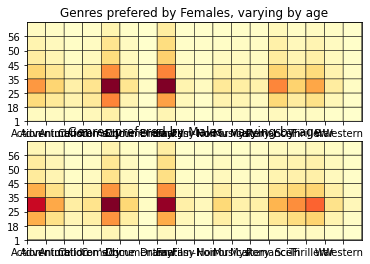

In [30]:
x = numpy.array([i for i in range(len(genres))])
y = numpy.array([i for i in range(len(ages))])

figure, (ax0, ax1) = plt.subplots(2, 1)

xyz = ax0.pcolor(female_genre_counts, cmap='YlOrRd', edgecolors='k', linewidth=0.5)
ax0.set_title("Genres prefered by Females, varying by age")

plt.sca(ax0)
plt.xticks(range(len(genres)), genres)
plt.yticks(range(len(ages)), ages)

xyz = ax1.pcolor(male_genre_counts, cmap='YlOrRd', edgecolors='k', linewidth=0.5)
ax1.set_title("Genres prefered by Males, varying by age")

plt.sca(ax1)
plt.xticks(range(len(genres)), genres)
plt.yticks(range(len(ages)), ages)

plt.show()

Analysis of Ratings of different Genres by, different Age and Gender group.

Similar to earlier analysis, first the data of female and male are extracted from user data, with their age.

In [31]:
female_data = users_data.loc[users_data['gender'] == 'F', ['user_id', 'age']]
male_data = users_data.loc[users_data['gender'] == 'M', ['user_id', 'age']]

Now, the data is merged with ratings data to get movie id, as well as the ratings given.

In [32]:
female_data = (female_data.merge(ratings_data, left_on='user_id', right_on='user_id')
               .reindex(columns=['age', 'user_id', 'movie_id', 'rating']))
male_data = (male_data.merge(ratings_data, left_on='user_id', right_on='user_id')
               .reindex(columns=['age', 'user_id', 'movie_id', 'rating']))

Just like before, the data is now merged with movies data to get the genre list. And then user id and movie id is dropped.

In [33]:
female_data = (female_data.merge(movie_data, left_on='movie_id', right_on='movie_id')
               .reindex(columns=['age', 'user_id', 'movie_id', 'genre', 'rating']))
male_data = (male_data.merge(movie_data, left_on='movie_id', right_on='movie_id')
               .reindex(columns=['age', 'user_id', 'movie_id', 'genre', 'rating']))

In [34]:
female_data.drop(['user_id', 'movie_id'], axis=1, inplace=True)
male_data.drop(['user_id', 'movie_id'], axis=1, inplace=True)

Again, the data is grouped by age for the analysis.

In [35]:
female_genre_data = female_data.groupby('age').agg(lambda x: x.tolist())
male_genre_data = male_data.groupby('age').agg(lambda x: x.tolist())

In [36]:
print(female_genre_data)
print(male_genre_data)

                                                 genre  \
age                                                      
1    [[Drama], [Drama], [Drama], [Drama], [Drama], ...   
18   [[Drama], [Drama], [Drama], [Drama], [Drama], ...   
25   [[Drama], [Drama], [Drama], [Drama], [Drama], ...   
35   [[Drama], [Drama], [Drama], [Drama], [Drama], ...   
45   [[Drama], [Drama], [Drama], [Drama], [Drama], ...   
50   [[Drama], [Drama], [Drama], [Drama], [Drama], ...   
56   [[Drama], [Drama], [Drama], [Drama], [Drama], ...   

                                                rating  
age                                                     
1    [5, 2, 5, 5, 4, 3, 3, 4, 4, 3, 3, 5, 1, 4, 2, ...  
18   [4, 4, 4, 4, 2, 5, 4, 3, 4, 5, 5, 5, 3, 4, 4, ...  
25   [5, 3, 5, 3, 4, 4, 5, 3, 5, 4, 5, 5, 5, 5, 3, ...  
35   [4, 4, 4, 5, 5, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, ...  
45   [5, 4, 3, 4, 4, 4, 5, 4, 5, 4, 5, 5, 5, 5, 5, ...  
50   [4, 4, 5, 5, 5, 1, 5, 5, 4, 4, 5, 5, 4, 5, 5, ...  
56   [5, 3, 5, 4, 5, 

As shown above, most of the job is done. Now, the task left is to map genre with its ratings. Since to access genre, the path is genre -> list for a age -> another list -> genre data, we need 3 for loops to access them. This is not at all efficient for larger datasets, and will look into better methods. For now, this should get the job done. So all the ratings for each age group's genre is appended to a list, and then averaged.

In [37]:
female_genre_ratings = {age: {key: [] for key in genres} for age in ages}
for age in ages:
    for genre, rating in zip(female_genre_data.loc[age, 'genre'], female_genre_data.loc[age, 'rating']):
        for indi_genre in genre:
            female_genre_ratings[age][indi_genre].append(rating)            
for age in ages:
    for genre in genres:
        female_genre_ratings[age][genre] = round(sum(female_genre_ratings[age][genre]) / len(female_genre_ratings[age][genre]),1)

male_genre_ratings = {age: {key: [] for key in genres} for age in ages}
for age in ages:
    for genre, rating in zip(male_genre_data.loc[age, 'genre'], male_genre_data.loc[age, 'rating']):
        for indi_genre in genre:
            male_genre_ratings[age][indi_genre].append(rating)
for age in ages:
    for genre in genres:
        male_genre_ratings[age][genre] = round(sum(male_genre_ratings[age][genre]) / len(male_genre_ratings[age][genre]), 1)

Data has to be in matrix for pcolor to work. So, data is put into a matrix form.

In [38]:
female_ratings = []
for age in ages:
    female_ratings.append(list(female_genre_ratings[age].values()))
    
male_ratings = []
for age in ages:
    male_ratings.append(list(male_genre_ratings[age].values()))

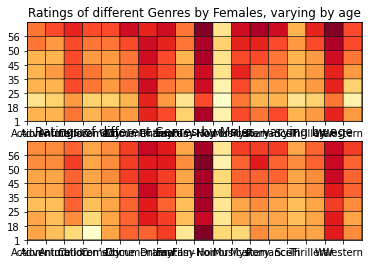

In [39]:
figure, (ax0, ax1) = plt.subplots(2, 1)

xyz = ax0.pcolor(female_ratings, cmap='YlOrRd', edgecolors='k', linewidth=0.5)
ax0.set_title("Ratings of different Genres by Females, varying by age")

plt.sca(ax0)
plt.xticks(range(len(genres)), genres)
plt.yticks(range(len(ages)), ages)

xyz = ax1.pcolor(male_ratings, cmap='YlOrRd', edgecolors='k', linewidth=0.5)
ax1.set_title("Ratings of different Genres by Males, varying by age")

plt.sca(ax1)
plt.xticks(range(len(genres)), genres)
plt.yticks(range(len(ages)), ages)

plt.show()